# Clustering com K-Prototype

#### Dataset Kaggle = https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis?select=marketing_campaign.csv

In [1]:
import random
# import joblib
# import pickle

import pandas as pd
import numpy as np
import seaborn as sns
# import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans #, DBSCAN, MeanShift, estimate_bandwidth
# from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, 
from sklearn.decomposition import PCA
from kneed import KneeLocator
from scipy.spatial import distance
from kmodes.kprototypes import KPrototypes
# from itertools import cycle

import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

### Carregando Dados

In [2]:
arq = 'dados/marketing_campaign.csv'

df_customer = pd.read_csv(arq, sep = '\t', header = 0)

In [3]:
df_customer.shape

(2240, 29)

In [4]:
df_customer.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [5]:
df_customer.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### Análise Exploratória

In [6]:
# Tipos dos Dados
df_customer.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

In [7]:
# Mudando variaveis int64 para bool
variaveis_booleanas = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
df_customer[variaveis_booleanas] = df_customer[variaveis_booleanas].astype(bool)
df_customer.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3              bool
AcceptedCmp4              bool
AcceptedCmp5              bool
AcceptedCmp1              bool
AcceptedCmp2              bool
Complain                  bool
Z_CostContact            int64
Z_Revenue                int64
Response                  bool
dtype: object

In [8]:
# Mudando variaveis object para datetime
df_customer['Dt_Customer'] = pd.to_datetime(df_customer['Dt_Customer'], format='%d-%m-%Y')
df_customer.dtypes

ID                              int64
Year_Birth                      int64
Education                      object
Marital_Status                 object
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                     bool
AcceptedCmp4                     bool
AcceptedCmp5                     bool
AcceptedCmp1                     bool
AcceptedCmp2                     bool
Complain                         bool
Z_CostContac

In [9]:
# Mudando variaveis int64 para float
produtos = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_customer[produtos] = df_customer[produtos].astype(float)
df_customer.dtypes

ID                              int64
Year_Birth                      int64
Education                      object
Marital_Status                 object
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                      float64
MntFruits                     float64
MntMeatProducts               float64
MntFishProducts               float64
MntSweetProducts              float64
MntGoldProds                  float64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                     bool
AcceptedCmp4                     bool
AcceptedCmp5                     bool
AcceptedCmp1                     bool
AcceptedCmp2                     bool
Complain                         bool
Z_CostContac

In [10]:
# Registros Nulos em branco
df_customer[df_customer.isnull().values]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
10,1994,1983,Graduation,Married,NaN,1,0,2013-11-15,11,5.0,...,7,False,False,False,False,False,False,3,11,False
27,5255,1986,Graduation,Single,NaN,1,0,2013-02-20,19,5.0,...,1,False,False,False,False,False,False,3,11,False
43,7281,1959,PhD,Single,NaN,0,0,2013-11-05,80,81.0,...,2,False,False,False,False,False,False,3,11,False
48,7244,1951,Graduation,Single,NaN,2,1,2014-01-01,96,48.0,...,6,False,False,False,False,False,False,3,11,False
58,8557,1982,Graduation,Single,NaN,1,0,2013-06-17,57,11.0,...,6,False,False,False,False,False,False,3,11,False
71,10629,1973,2n Cycle,Married,NaN,1,0,2012-09-14,25,25.0,...,8,False,False,False,False,False,False,3,11,False
90,8996,1957,PhD,Married,NaN,2,1,2012-11-19,4,230.0,...,9,False,False,False,False,False,False,3,11,False
91,9235,1957,Graduation,Single,NaN,1,1,2014-05-27,45,7.0,...,7,False,False,False,False,False,False,3,11,False
92,5798,1973,Master,Together,NaN,0,0,2013-11-23,87,445.0,...,1,False,False,False,False,False,False,3,11,False
128,8268,1961,PhD,Married,NaN,0,1,2013-07-11,23,352.0,...,6,False,False,False,False,False,False,3,11,False


In [11]:
# Preenchendo 24 registros com a media - Como cada registro se trata de um cliente único, para não ter clientes sem cluster preenchemos com a media
df_customer['Income'] = df_customer['Income'].fillna(df_customer['Income'].mean())
df_customer[df_customer.isnull().values]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response


In [12]:
# Registros duplicados
df_customer[df_customer.duplicated(keep = False)]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response


In [13]:
# Separando colunas objects e não objects para analise de variaveis numericas e não numericas
colunas_object = df_customer.select_dtypes(include=['object', 'bool'])

colunas_nao_object = df_customer.select_dtypes(exclude=['object', 'bool'])

#### - Variáveis Numéricas

In [14]:
colunas_nao_object.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,2013-07-10 10:01:42.857142784,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,3.0,11.0
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,2012-07-30 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0
25%,2828.250000,1959.000000,35538.750000,0.000000,0.000000,2013-01-16 00:00:00,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,3.0,11.0
50%,5458.500000,1970.000000,51741.500000,0.000000,0.000000,2013-07-08 12:00:00,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,3.0,11.0
75%,8427.750000,1977.000000,68289.750000,1.000000,1.000000,2013-12-30 06:00:00,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,3.0,11.0
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,2014-06-29 00:00:00,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,3.0,11.0
std,3246.662198,11.984069,25037.797168,0.538398,0.544538,NaN,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.0,0.0


In [15]:
# Cada ID é um cliente único, definindo
df_customer = df_customer.set_index('ID')
col_num = df_customer.select_dtypes(include=['number'])
df_customer

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635.0,88.0,...,7,False,False,False,False,False,False,3,11,True
2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11.0,1.0,...,5,False,False,False,False,False,False,3,11,False
4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426.0,49.0,...,4,False,False,False,False,False,False,3,11,False
6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11.0,4.0,...,6,False,False,False,False,False,False,3,11,False
5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173.0,43.0,...,5,False,False,False,False,False,False,3,11,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709.0,43.0,...,5,False,False,False,False,False,False,3,11,False
4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406.0,0.0,...,7,False,False,False,True,False,False,3,11,False
7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908.0,48.0,...,6,False,True,False,False,False,False,3,11,False


In [16]:
# Criando coluna idade 
df_customer.insert(1, 'Age', 2016 - df_customer['Year_Birth'])
colunas_nao_object = df_customer.select_dtypes(exclude=['object', 'bool'])
colunas_nao_object.describe()

,Year_Birth,Age,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0
mean,1968.805804,47.194196,52247.251354,0.444196,0.506250,2013-07-10 10:01:42.857142784,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,3.0,11.0
min,1893.000000,20.000000,1730.000000,0.000000,0.000000,2012-07-30 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0
25%,1959.000000,39.000000,35538.750000,0.000000,0.000000,2013-01-16 00:00:00,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,3.0,11.0
50%,1970.000000,46.000000,51741.500000,0.000000,0.000000,2013-07-08 12:00:00,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,3.0,11.0
75%,1977.000000,57.000000,68289.750000,1.000000,1.000000,2013-12-30 06:00:00,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,3.0,11.0
max,1996.000000,123.000000,666666.000000,2.000000,2.000000,2014-06-29 00:00:00,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,3.0,11.0
std,11.984069,11.984069,25037.797168,0.538398,0.544538,NaN,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.0,0.0


In [17]:
df_customer['Year_Birth'].sort_values()

ID
11004    1893
1150     1899
7829     1900
6663     1940
6932     1941
         ... 
10548    1995
4427     1995
8315     1995
193      1996
9909     1996
Name: Year_Birth, Length: 2240, dtype: int64

In [18]:
df_customer[(df_customer['Year_Birth'] >= 1893) & (df_customer['Year_Birth'] <= 1939)]  

,Year_Birth,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
7829,1900,116,2n Cycle,Divorced,36640.0,1,0,2013-09-26,99,15.0,...,5,False,False,False,False,False,True,3,11,False
11004,1893,123,2n Cycle,Single,60182.0,0,1,2014-05-17,23,8.0,...,4,False,False,False,False,False,False,3,11,False
1150,1899,117,PhD,Together,83532.0,0,0,2013-09-26,36,755.0,...,1,False,False,True,False,False,False,3,11,False


In [19]:
# Definindo o valor minimo de ano de nascimento como 1940, mantemos o registro e colocamos o valor dentro de um valor aceitavel 
df_customer = df_customer.drop(
    df_customer[(df_customer['Year_Birth'] >= 1893) & (df_customer['Year_Birth'] <= 1939)].index
)

df_customer = df_customer.drop(columns=['Year_Birth'])

df_customer.describe()

,Age,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue
count,2237.000000,2237.000000,2237.000000,2237.000000,2237,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.0,2237.0
mean,47.098346,52236.696036,0.444345,0.506482,2013-07-10 05:01:54.260169728,49.104604,303.995530,26.270451,166.916853,37.523022,27.068842,43.968708,2.326777,4.087170,2.662494,5.794367,5.319177,3.0,11.0
min,20.000000,1730.000000,0.000000,0.000000,2012-07-30 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0
25%,39.000000,35523.000000,0.000000,0.000000,2013-01-16 00:00:00,24.000000,24.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,3.0,11.0
50%,46.000000,51717.000000,0.000000,0.000000,2013-07-08 00:00:00,49.000000,174.000000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,3.0,11.0
75%,57.000000,68281.000000,1.000000,1.000000,2013-12-30 00:00:00,74.000000,504.000000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,3.0,11.0
max,76.000000,666666.000000,2.000000,2.000000,2014-06-29 00:00:00,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,3.0,11.0
std,11.701917,25043.111847,0.538467,0.544593,NaN,28.956073,336.574382,39.715972,225.661158,54.639909,41.293949,52.054318,1.932923,2.779461,2.923456,3.250940,2.426386,0.0,0.0


In [20]:
colunas_nao_object = df_customer.select_dtypes(exclude=['object', 'bool'])
colunas_nao_object.describe()

,Age,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue
count,2237.000000,2237.000000,2237.000000,2237.000000,2237,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.000000,2237.0,2237.0
mean,47.098346,52236.696036,0.444345,0.506482,2013-07-10 05:01:54.260169728,49.104604,303.995530,26.270451,166.916853,37.523022,27.068842,43.968708,2.326777,4.087170,2.662494,5.794367,5.319177,3.0,11.0
min,20.000000,1730.000000,0.000000,0.000000,2012-07-30 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0
25%,39.000000,35523.000000,0.000000,0.000000,2013-01-16 00:00:00,24.000000,24.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,3.0,11.0
50%,46.000000,51717.000000,0.000000,0.000000,2013-07-08 00:00:00,49.000000,174.000000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,3.0,11.0
75%,57.000000,68281.000000,1.000000,1.000000,2013-12-30 00:00:00,74.000000,504.000000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,3.0,11.0
max,76.000000,666666.000000,2.000000,2.000000,2014-06-29 00:00:00,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,3.0,11.0
std,11.701917,25043.111847,0.538467,0.544593,NaN,28.956073,336.574382,39.715972,225.661158,54.639909,41.293949,52.054318,1.932923,2.779461,2.923456,3.250940,2.426386,0.0,0.0


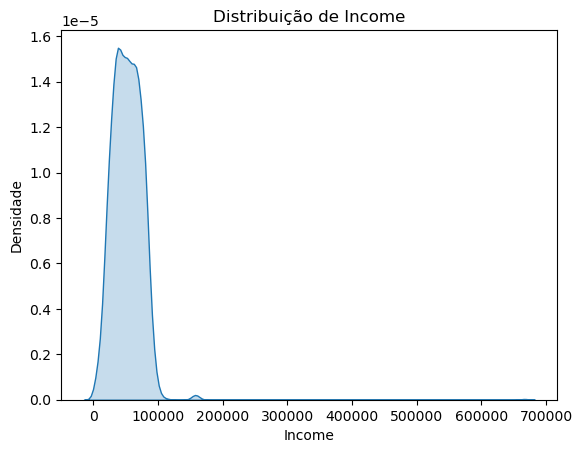

In [21]:
# Distribuição KDE variavel Income
sns.kdeplot(df_customer['Income'], shade=True) 

plt.title('Distribuição de Income')
plt.xlabel('Income')
plt.ylabel('Densidade')

plt.show()

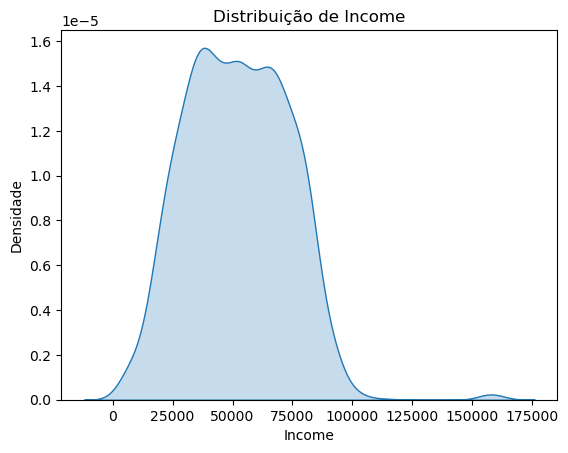

In [22]:
# Como existe apenas 1 registro acima de 200000, removemos para não impactar no clustering
indice = df_customer[df_customer['Income'] >= 200000].index

df_customer = df_customer.drop(indice)

sns.kdeplot(df_customer['Income'], shade=True) 

plt.title('Distribuição de Income')
plt.xlabel('Income')
plt.ylabel('Densidade')

plt.show()

In [23]:
# Criando a coluna meses de relacionamento para transformar data em algo mensurável, e drop na coluna Dt_Cliente, pois essa informação agora é a quantidade de meses de relacionamento
data_final = pd.to_datetime('2016-12-31')

df_customer['Month_Rel'] = (
    ((data_final.year - df_customer['Dt_Customer'].dt.year) * 12) +
    (data_final.month - df_customer['Dt_Customer'].dt.month)
)

df_customer.insert(6, 'Month_Rel', df_customer.pop('Month_Rel'))

df_customer = df_customer.drop(columns=['Dt_Customer'])

df_customer

,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Month_Rel,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,59,Graduation,Single,58138.0,0,0,51,58,635.0,88.0,...,7,False,False,False,False,False,False,3,11,True
2174,62,Graduation,Single,46344.0,1,1,33,38,11.0,1.0,...,5,False,False,False,False,False,False,3,11,False
4141,51,Graduation,Together,71613.0,0,0,40,26,426.0,49.0,...,4,False,False,False,False,False,False,3,11,False
6182,32,Graduation,Together,26646.0,1,0,34,26,11.0,4.0,...,6,False,False,False,False,False,False,3,11,False
5324,35,PhD,Married,58293.0,1,0,35,94,173.0,43.0,...,5,False,False,False,False,False,False,3,11,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,49,Graduation,Married,61223.0,0,1,42,46,709.0,43.0,...,5,False,False,False,False,False,False,3,11,False
4001,70,PhD,Together,64014.0,2,1,30,56,406.0,0.0,...,7,False,False,False,True,False,False,3,11,False
7270,35,Graduation,Divorced,56981.0,0,0,35,91,908.0,48.0,...,6,False,True,False,False,False,False,3,11,False


In [24]:
colunas_nao_object = df_customer.select_dtypes(exclude=['object', 'bool'])
colunas_nao_object.describe()

,Age,Income,Kidhome,Teenhome,Month_Rel,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.00000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.0,2236.0
mean,47.101968,51961.906544,0.444097,0.506708,41.201252,49.116279,304.12746,26.275939,166.983453,37.536225,27.080501,43.983005,2.326029,4.087657,2.663238,5.795617,5.318873,3.0,11.0
std,11.703281,21411.404811,0.538459,0.544609,6.641994,28.957284,336.59181,39.724007,225.689645,54.648562,41.299504,52.061568,1.933032,2.779988,2.923898,3.251129,2.426886,0.0,0.0
min,20.000000,1730.000000,0.000000,0.000000,30.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0
25%,39.000000,35502.500000,0.000000,0.000000,36.000000,24.000000,24.00000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,3.0,11.0
50%,46.000000,51684.000000,0.000000,0.000000,41.000000,49.000000,174.00000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,3.0,11.0
75%,57.000000,68275.750000,1.000000,1.000000,47.000000,74.000000,504.25000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,3.0,11.0
max,76.000000,162397.000000,2.000000,2.000000,53.000000,99.000000,1493.00000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,3.0,11.0


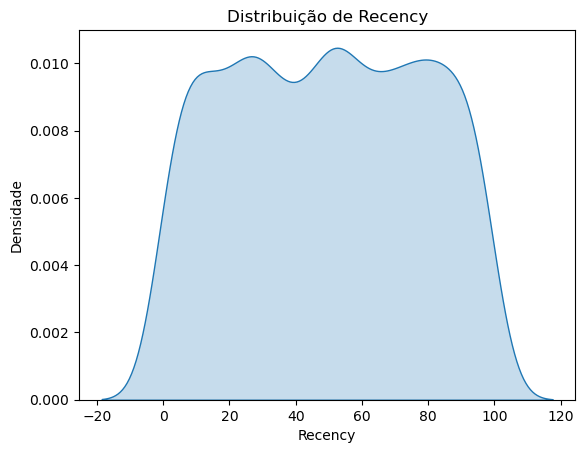

In [25]:
# Distribuição KDE variavel Recency
sns.kdeplot(df_customer['Recency'], shade=True) 

plt.title('Distribuição de Recency')
plt.xlabel('Recency')
plt.ylabel('Densidade')

plt.show()

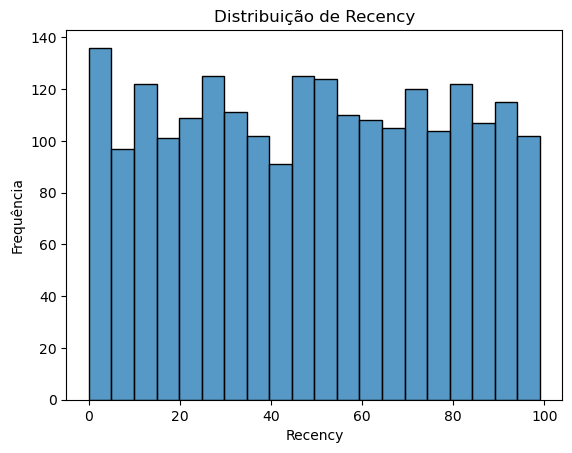

In [26]:
# Gerando o histograma para a coluna 'Recency'
sns.histplot(df_customer['Recency'], kde=False, bins=20)

plt.title('Distribuição de Recency')
plt.xlabel('Recency')
plt.ylabel('Frequência')

plt.show()

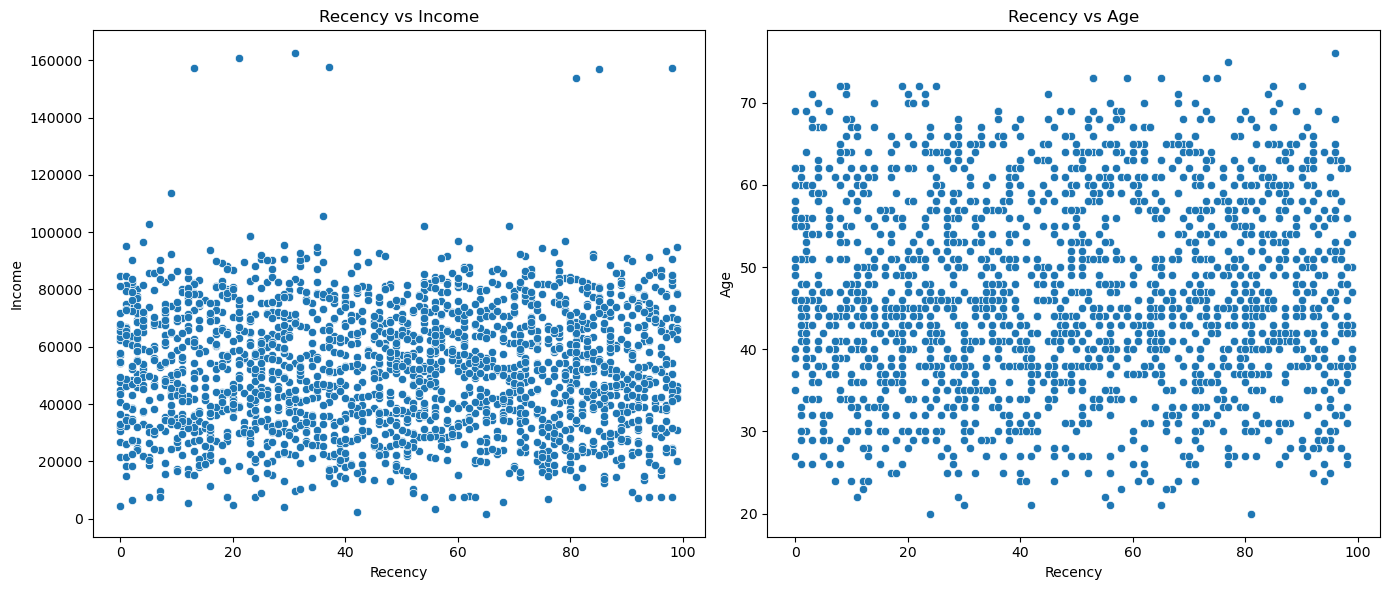

In [27]:
# scatterplots Recency x Age e Recency x Income
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x='Recency', y='Income', data=df_customer, ax=axs[0])
axs[0].set_title('Recency vs Income')
axs[0].set_xlabel('Recency')
axs[0].set_ylabel('Income')

sns.scatterplot(x='Recency', y='Age', data=df_customer, ax=axs[1])
axs[1].set_title('Recency vs Age')
axs[1].set_xlabel('Recency')
axs[1].set_ylabel('Age')

plt.tight_layout()

plt.show()

In [28]:
# Variavel Recency esta sem padrão, decisão remover
df_customer = df_customer.drop(columns='Recency')

In [29]:
# Colunas Z_CostContact e Z_Revenue possui apenas os valore 3 e 11 respectivamente, não impactando na clusterizaçõ, por isso remove
df_customer = df_customer.drop(columns=['Z_CostContact', 'Z_Revenue'])

In [30]:
colunas_nao_object = df_customer.select_dtypes(exclude=['object', 'bool'])
colunas_nao_object.describe()

,Age,Income,Kidhome,Teenhome,Month_Rel,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.00000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,47.101968,51961.906544,0.444097,0.506708,41.201252,304.12746,26.275939,166.983453,37.536225,27.080501,43.983005,2.326029,4.087657,2.663238,5.795617,5.318873
std,11.703281,21411.404811,0.538459,0.544609,6.641994,336.59181,39.724007,225.689645,54.648562,41.299504,52.061568,1.933032,2.779988,2.923898,3.251129,2.426886
min,20.000000,1730.000000,0.000000,0.000000,30.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,35502.500000,0.000000,0.000000,36.000000,24.00000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000
50%,46.000000,51684.000000,0.000000,0.000000,41.000000,174.00000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000
75%,57.000000,68275.750000,1.000000,1.000000,47.000000,504.25000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000
max,76.000000,162397.000000,2.000000,2.000000,53.000000,1493.00000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000


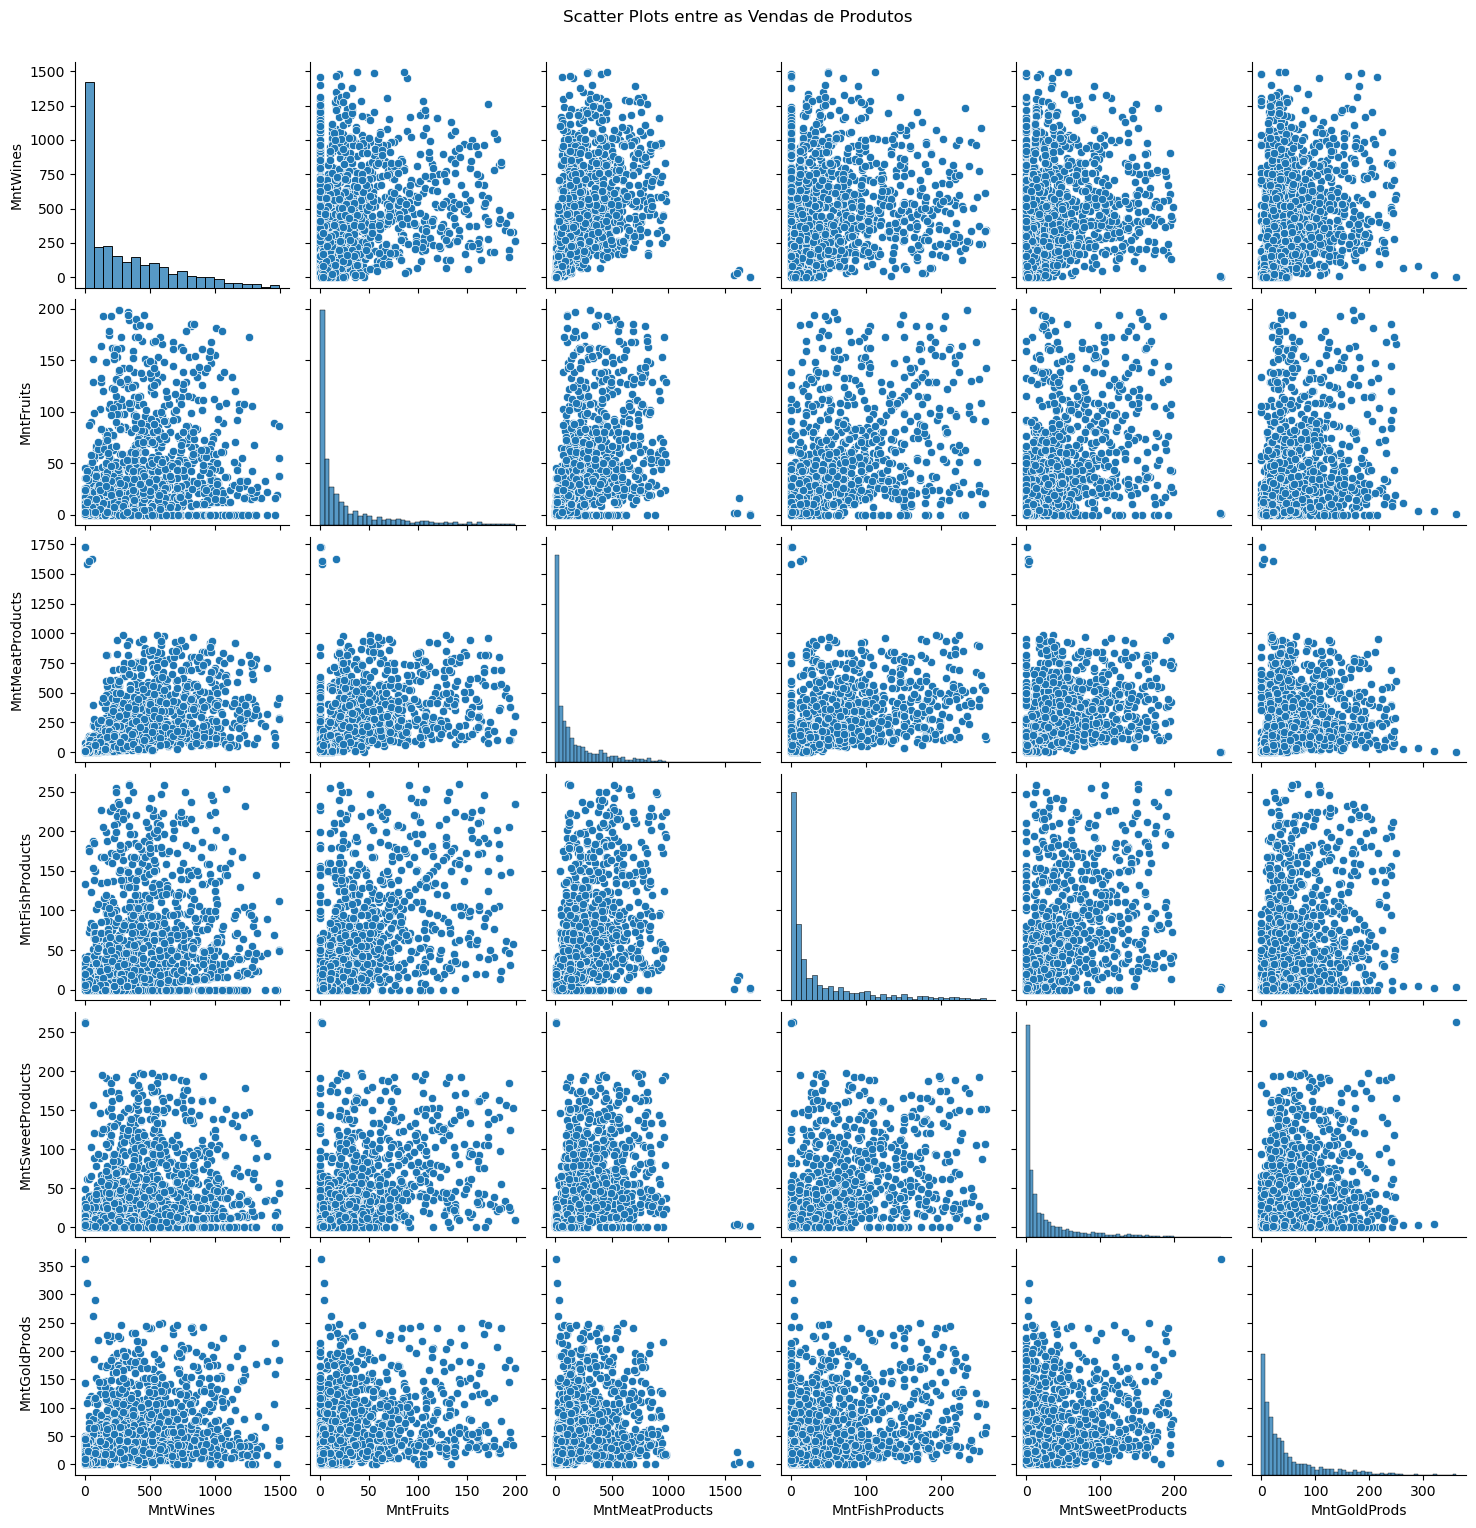

In [31]:
# PairPlot de todos Corr x Sell todos os produtos

sns.pairplot(df_customer[produtos])
plt.suptitle('Scatter Plots entre as Vendas de Produtos', y=1.02)
plt.show()

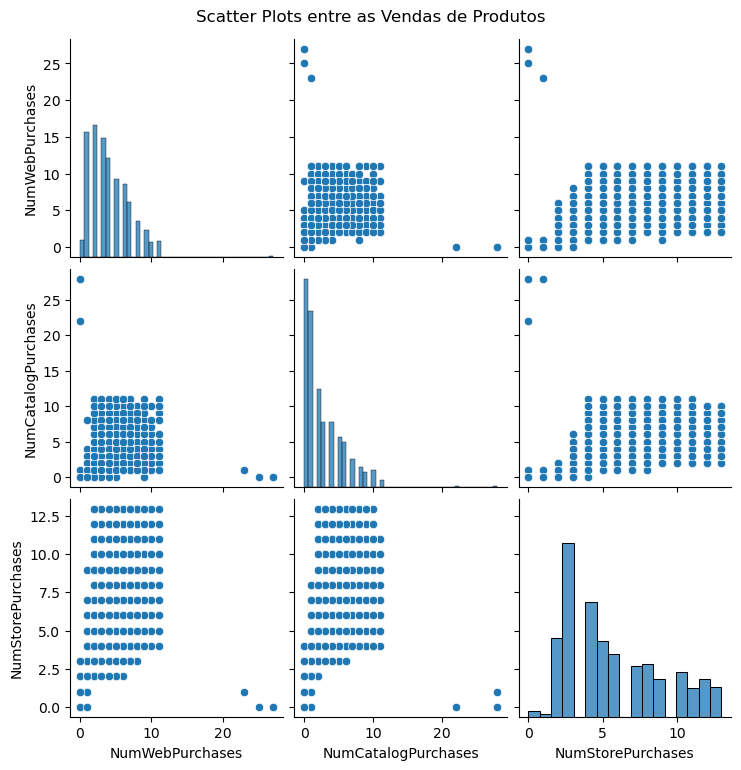

In [32]:
# PairPlot de todos Corr x Local todos os Locais de vendas
locais = ['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']

sns.pairplot(df_customer[locais])
plt.suptitle('Scatter Plots entre as Vendas de Produtos', y=1.02)
plt.show()

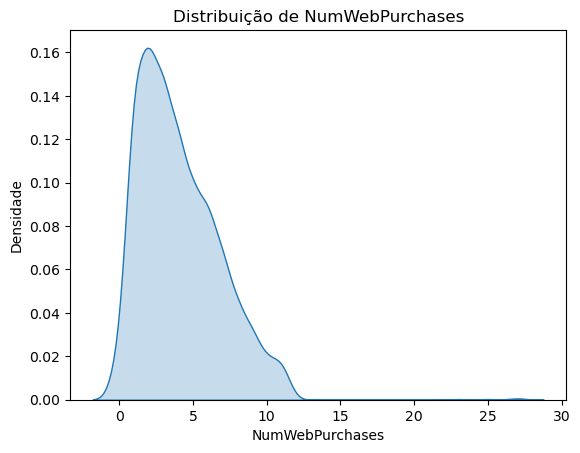

In [33]:
# Distribuição KDE variavel NumWebPurchase
sns.kdeplot(df_customer['NumWebPurchases'], shade=True) 

plt.title('Distribuição de NumWebPurchases')
plt.xlabel('NumWebPurchases')
plt.ylabel('Densidade')

plt.show()

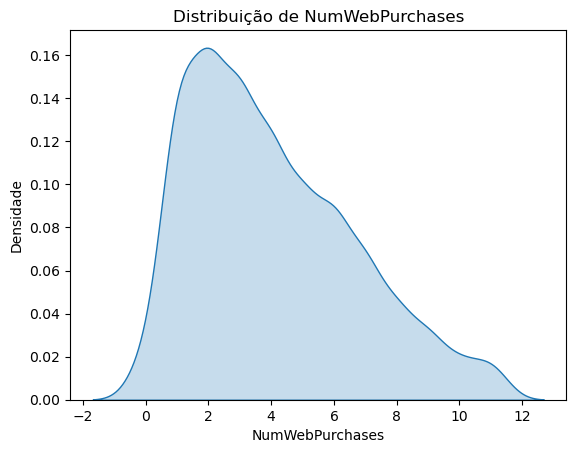

In [34]:
indice = df_customer[df_customer['NumWebPurchases'] >= 15].index

df_customer = df_customer.drop(indice)

sns.kdeplot(df_customer['NumWebPurchases'], shade=True) 

plt.title('Distribuição de NumWebPurchases')
plt.xlabel('NumWebPurchases')
plt.ylabel('Densidade')

plt.show()

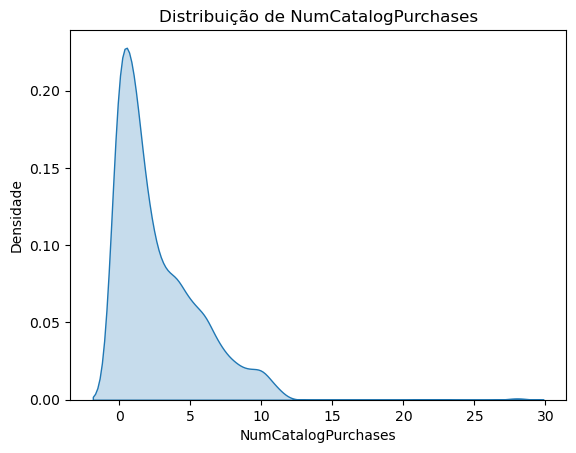

In [35]:
# Distribuição KDE variavel NumWebPurchase
sns.kdeplot(df_customer['NumCatalogPurchases'], shade=True) 

plt.title('Distribuição de NumCatalogPurchases')
plt.xlabel('NumCatalogPurchases')
plt.ylabel('Densidade')

plt.show()

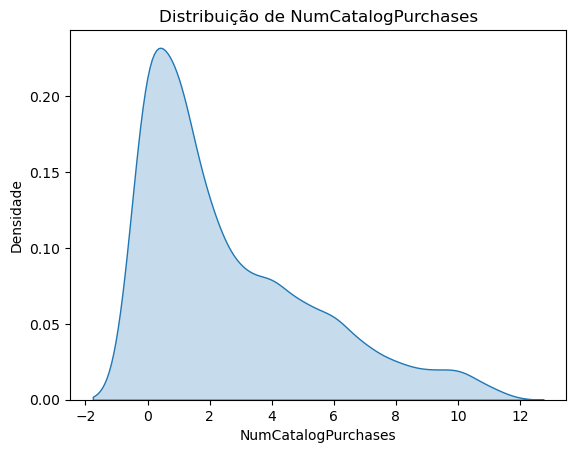

In [36]:
indice = df_customer[df_customer['NumCatalogPurchases'] >= 15].index

df_customer = df_customer.drop(indice)

sns.kdeplot(df_customer['NumCatalogPurchases'], shade=True) 

plt.title('Distribuição de NumCatalogPurchases')
plt.xlabel('NumCatalogPurchases')
plt.ylabel('Densidade')

plt.show()

In [37]:
#Total Clientes
qtd_cliente = df_customer.index.nunique()
print(f'Número de clientes únicos: {qtd_cliente}')

Número de clientes únicos: 2228


In [38]:
df_customer

,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Month_Rel,MntWines,MntFruits,MntMeatProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,59,Graduation,Single,58138.0,0,0,51,635.0,88.0,546.0,...,10,4,7,False,False,False,False,False,False,True
2174,62,Graduation,Single,46344.0,1,1,33,11.0,1.0,6.0,...,1,2,5,False,False,False,False,False,False,False
4141,51,Graduation,Together,71613.0,0,0,40,426.0,49.0,127.0,...,2,10,4,False,False,False,False,False,False,False
6182,32,Graduation,Together,26646.0,1,0,34,11.0,4.0,20.0,...,0,4,6,False,False,False,False,False,False,False
5324,35,PhD,Married,58293.0,1,0,35,173.0,43.0,118.0,...,3,6,5,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,49,Graduation,Married,61223.0,0,1,42,709.0,43.0,182.0,...,3,4,5,False,False,False,False,False,False,False
4001,70,PhD,Together,64014.0,2,1,30,406.0,0.0,30.0,...,2,5,7,False,False,False,True,False,False,False
7270,35,Graduation,Divorced,56981.0,0,0,35,908.0,48.0,217.0,...,3,13,6,False,True,False,False,False,False,False


In [39]:
df_customer[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Complain','Response']] = df_customer[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Complain','Response']].astype(int)
df_customer[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Complain','Response']] = df_customer[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Complain','Response']].astype(object)
df_customer.dtypes

Age                      int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Month_Rel                int32
MntWines               float64
MntFruits              float64
MntMeatProducts        float64
MntFishProducts        float64
MntSweetProducts       float64
MntGoldProds           float64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3            object
AcceptedCmp4            object
AcceptedCmp5            object
AcceptedCmp1            object
AcceptedCmp2            object
Complain                object
Response                object
dtype: object

In [40]:
colunas_nao_object = df_customer.select_dtypes(exclude=['object'])
colunas_object = df_customer.select_dtypes(include=['object'])
colunas_nao_object.describe()

,Age,Income,Kidhome,Teenhome,Month_Rel,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000
mean,47.113555,51854.412379,0.444794,0.506732,41.202424,305.136445,26.356822,164.573609,37.656643,26.936266,43.699282,2.314183,4.056553,2.624776,5.815530,5.335727
std,11.700734,20978.276937,0.538675,0.543938,6.640750,336.769433,39.771255,216.887689,54.708742,40.746861,51.076725,1.876529,2.626150,2.744985,3.239794,2.414676
min,20.000000,1730.000000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,35538.750000,0.000000,0.000000,36.000000,24.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000
50%,46.000000,51650.500000,0.000000,0.000000,41.000000,176.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000
75%,57.000000,68143.500000,1.000000,1.000000,47.000000,505.000000,33.000000,230.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000
max,76.000000,162397.000000,2.000000,2.000000,53.000000,1493.000000,199.000000,1607.000000,259.000000,198.000000,262.000000,15.000000,11.000000,11.000000,13.000000,20.000000


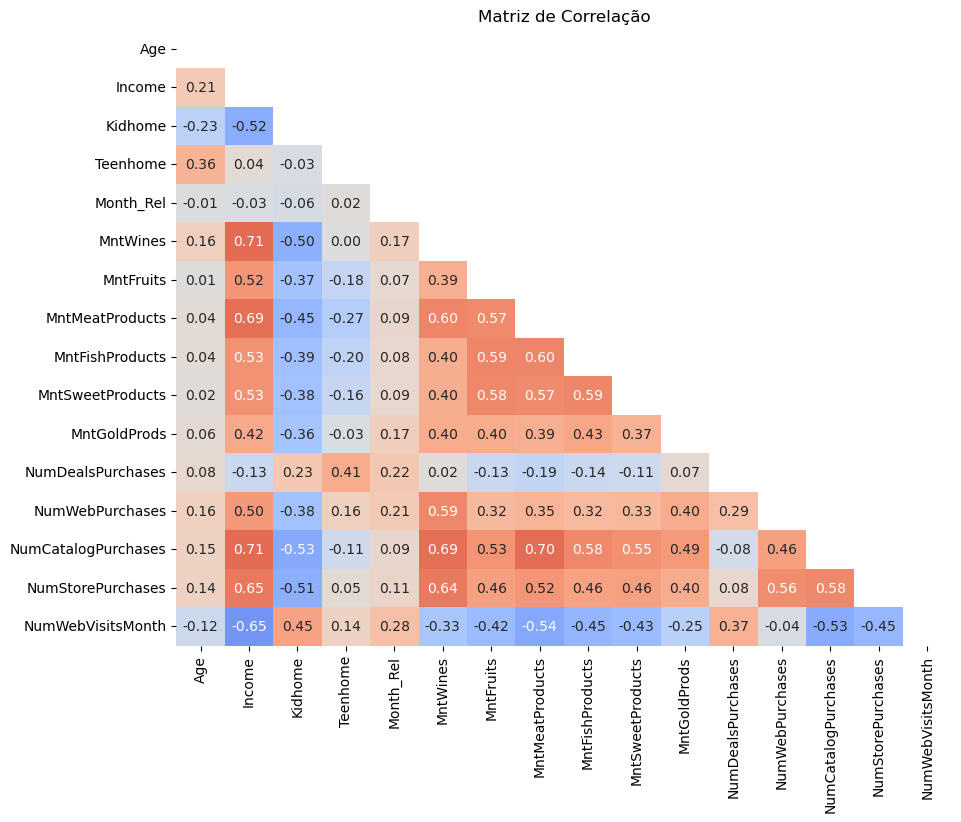

In [41]:
correlation_matrix = colunas_nao_object.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1,
            cbar=False, 
            square=False)
ax.set_title('Matriz de Correlação')

#salvando figura
#fig.savefig('corr.png', format='png')
plt.show() 

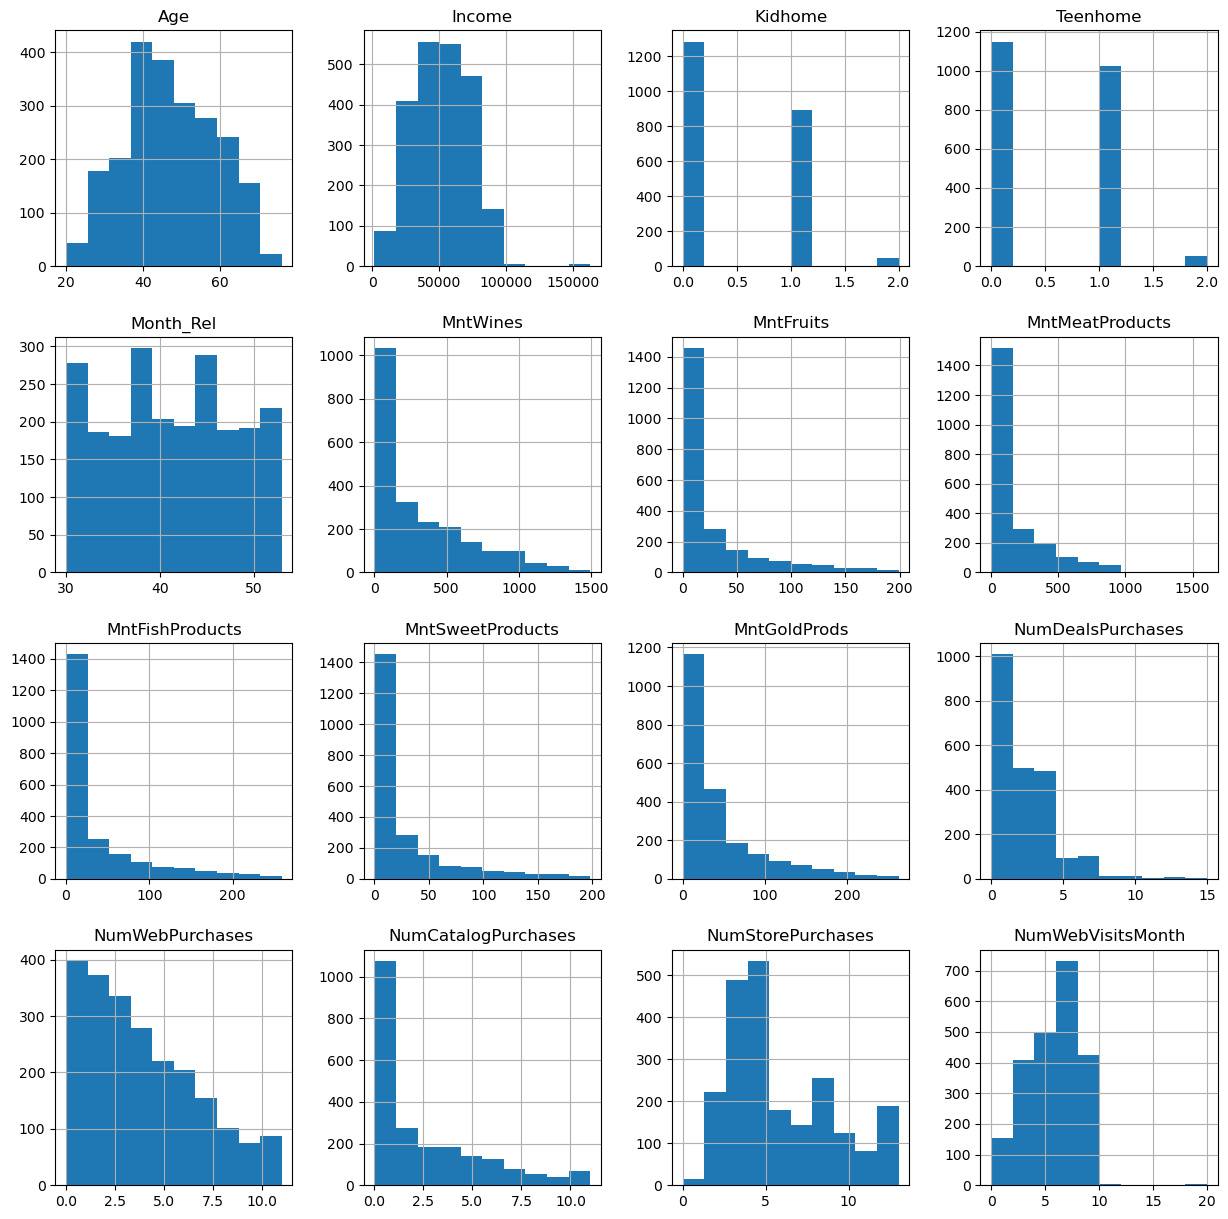

In [42]:
colunas_nao_object.hist(figsize = (15,15), bins = 10)
plt.show()

#### - Variáveis Categoricas

In [43]:
colunas_object.describe()

,Education,Marital_Status,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
count,2228,2228,2228,2228,2228,2228,2228,2228,2228
unique,5,8,2,2,2,2,2,2,2
top,Graduation,Married,0,0,0,0,0,0,0
freq,1122,860,2065,2061,2066,2084,2198,2208,1894


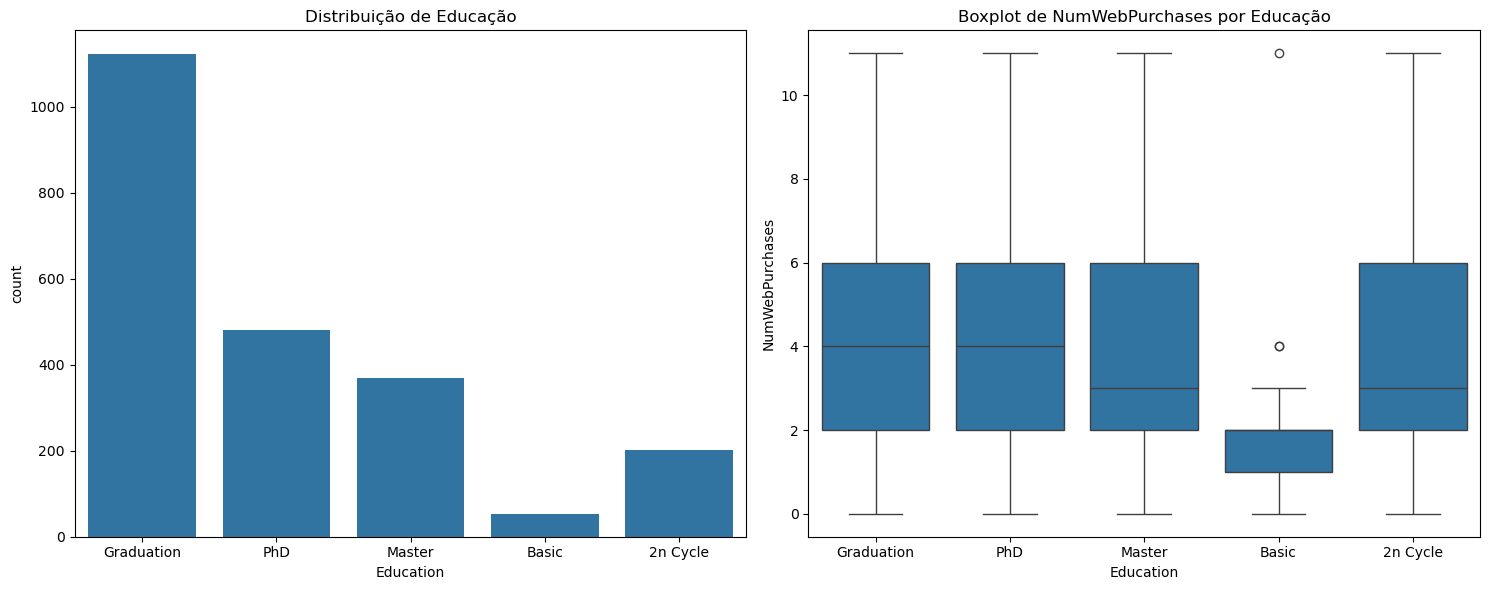

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=df_customer, x='Education', ax=axes[0])
axes[0].set_title('Distribuição de Educação')

sns.boxplot(data=df_customer, x='Education', y='NumWebPurchases', ax=axes[1])
axes[1].set_title('Boxplot de NumWebPurchases por Educação')

plt.tight_layout() 
plt.show()

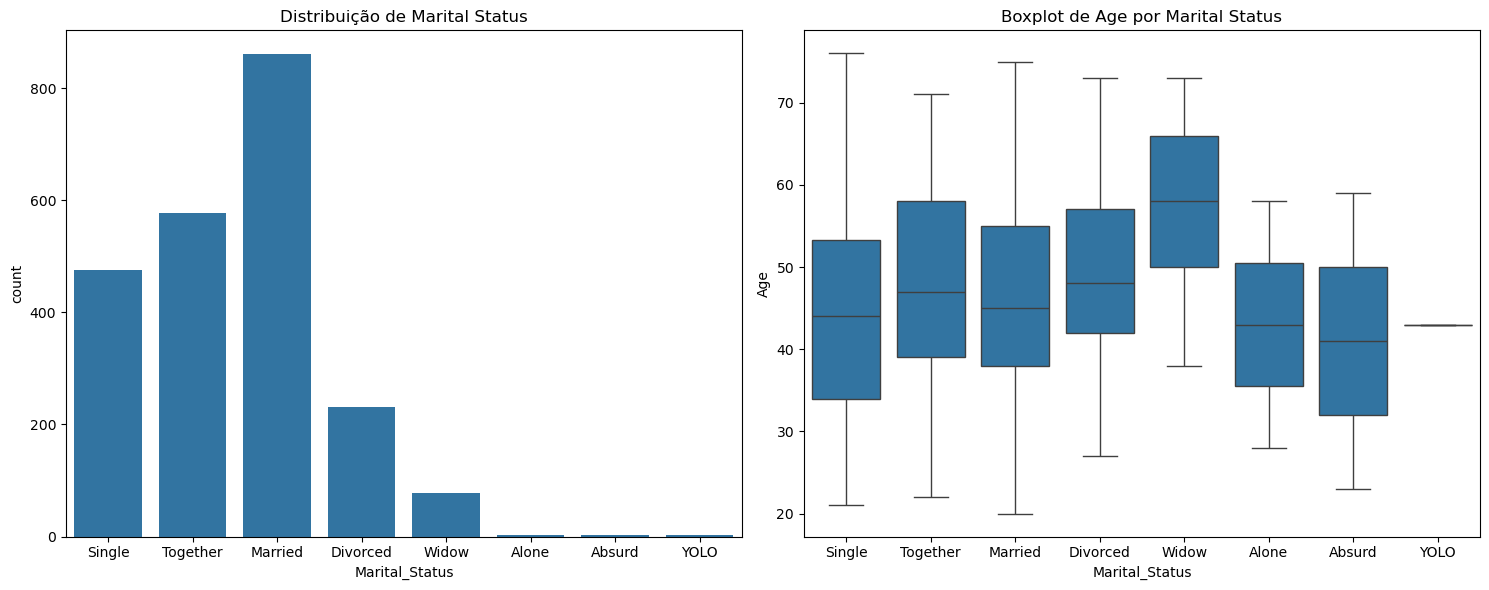

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=df_customer, x='Marital_Status', ax=axes[0])
axes[0].set_title('Distribuição de Marital Status')

sns.boxplot(data=df_customer, x='Marital_Status', y='Age', ax=axes[1])
axes[1].set_title('Boxplot de Age por Marital Status')

plt.tight_layout() 
plt.show()

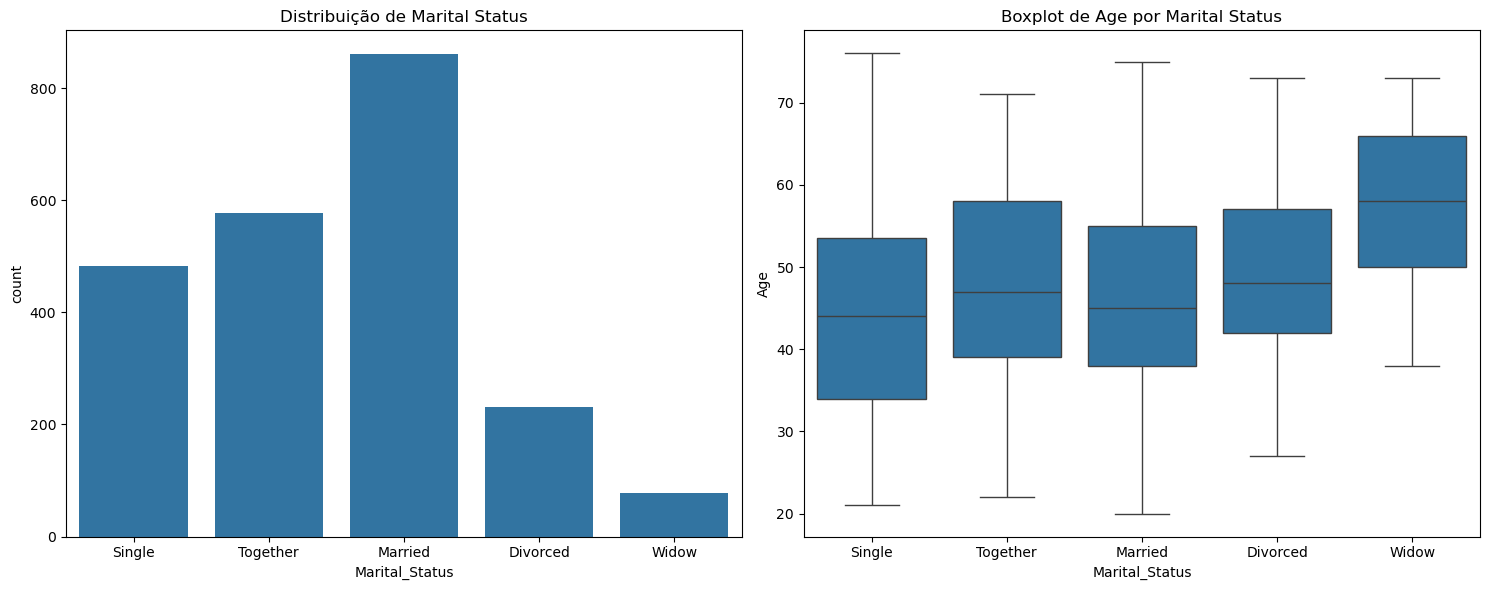

In [46]:
# Definindo Alone, Absurd e YOLO todos como Single
df_customer['Marital_Status'] = df_customer['Marital_Status'].replace(['YOLO', 'Alone', 'Absurd'], 'Single')

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=df_customer, x='Marital_Status', ax=axes[0])
axes[0].set_title('Distribuição de Marital Status')

sns.boxplot(data=df_customer, x='Marital_Status', y='Age', ax=axes[1])
axes[1].set_title('Boxplot de Age por Marital Status')

plt.tight_layout() 
plt.show()

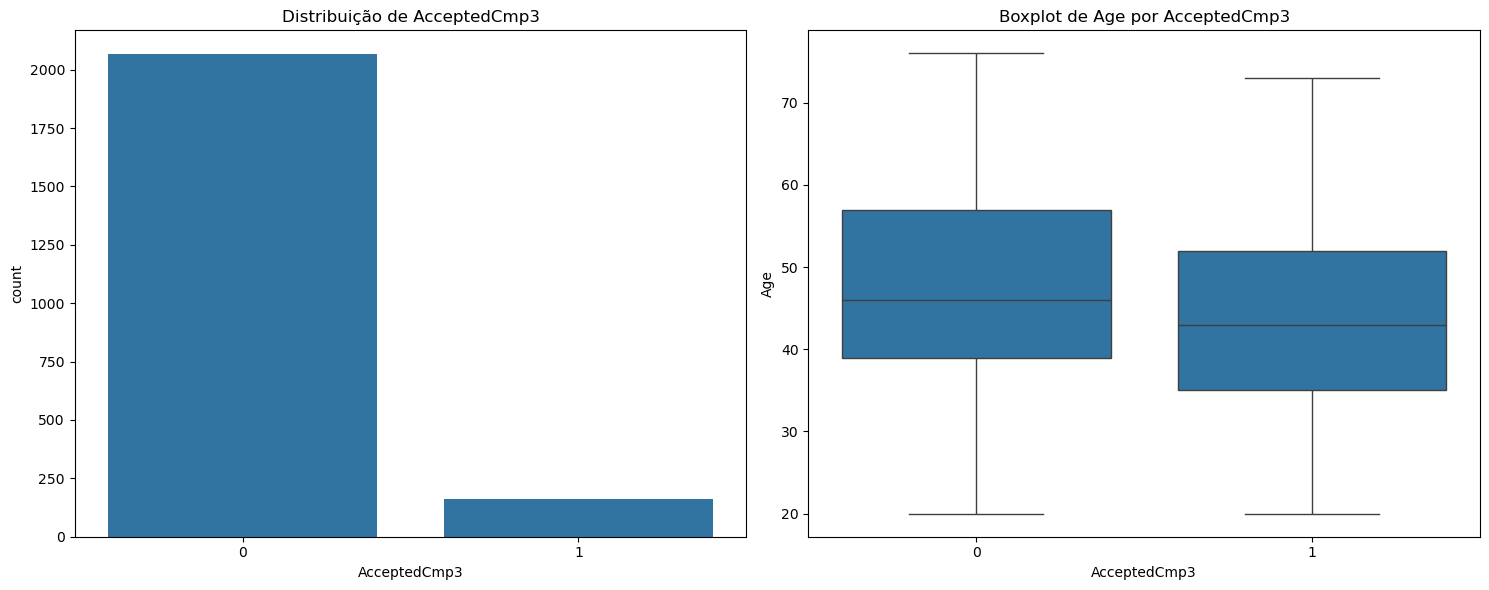

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=df_customer, x='AcceptedCmp3', ax=axes[0])
axes[0].set_title('Distribuição de AcceptedCmp3')

sns.boxplot(data=df_customer, x='AcceptedCmp3', y='Age', ax=axes[1])
axes[1].set_title('Boxplot de Age por AcceptedCmp3')

plt.tight_layout() 
plt.show()

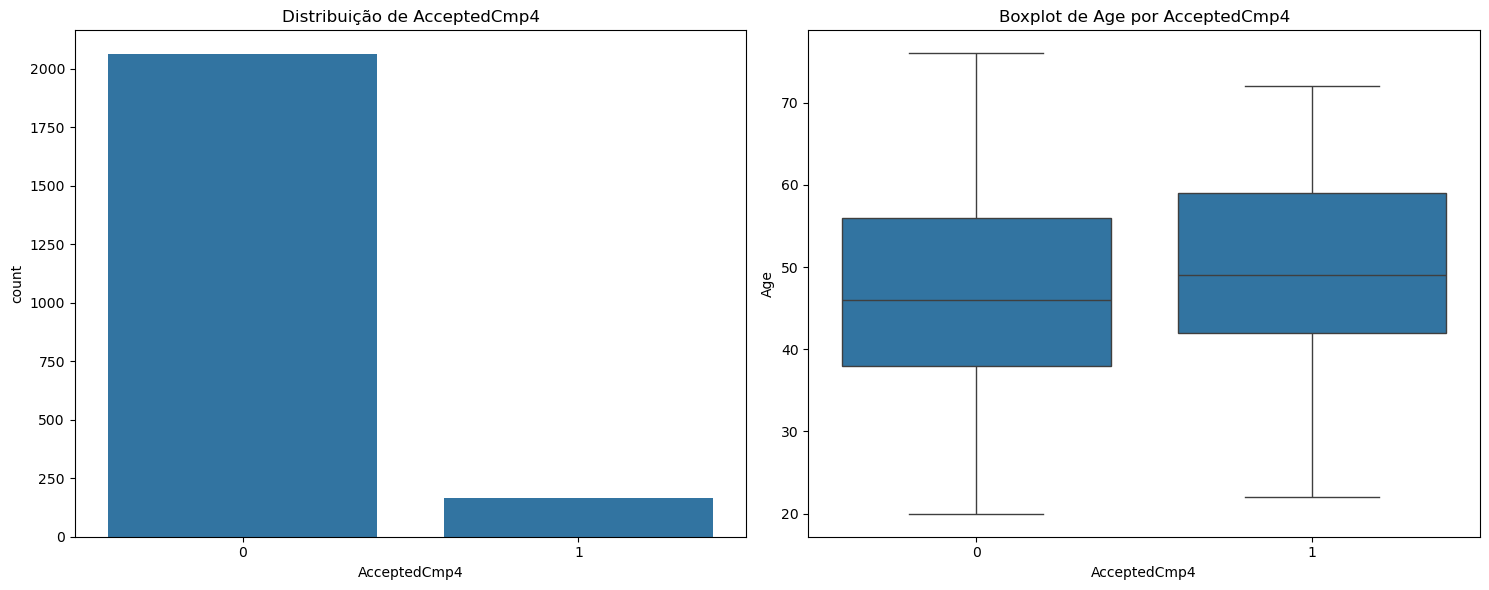

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=df_customer, x='AcceptedCmp4', ax=axes[0])
axes[0].set_title('Distribuição de AcceptedCmp4')

sns.boxplot(data=df_customer, x='AcceptedCmp4', y='Age', ax=axes[1])
axes[1].set_title('Boxplot de Age por AcceptedCmp4')

plt.tight_layout() 
plt.show()

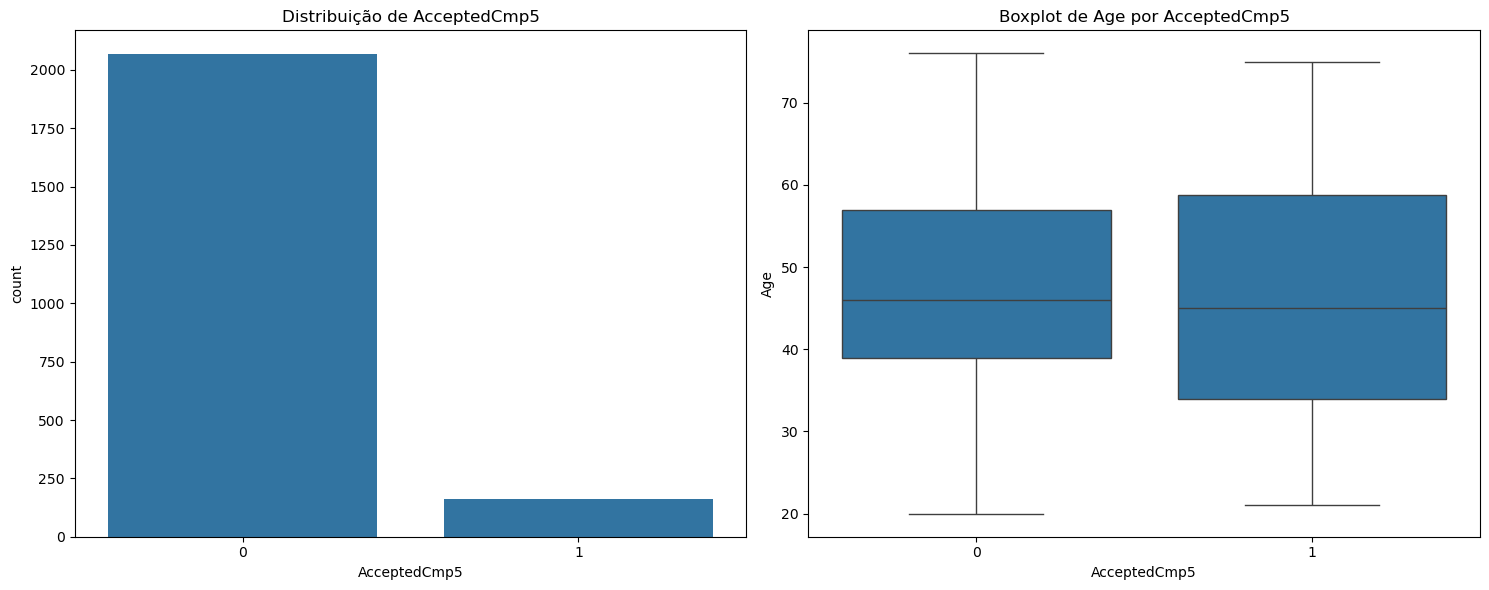

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=df_customer, x='AcceptedCmp5', ax=axes[0])
axes[0].set_title('Distribuição de AcceptedCmp5')

sns.boxplot(data=df_customer, x='AcceptedCmp5', y='Age', ax=axes[1])
axes[1].set_title('Boxplot de Age por AcceptedCmp5')

plt.tight_layout() 
plt.show()

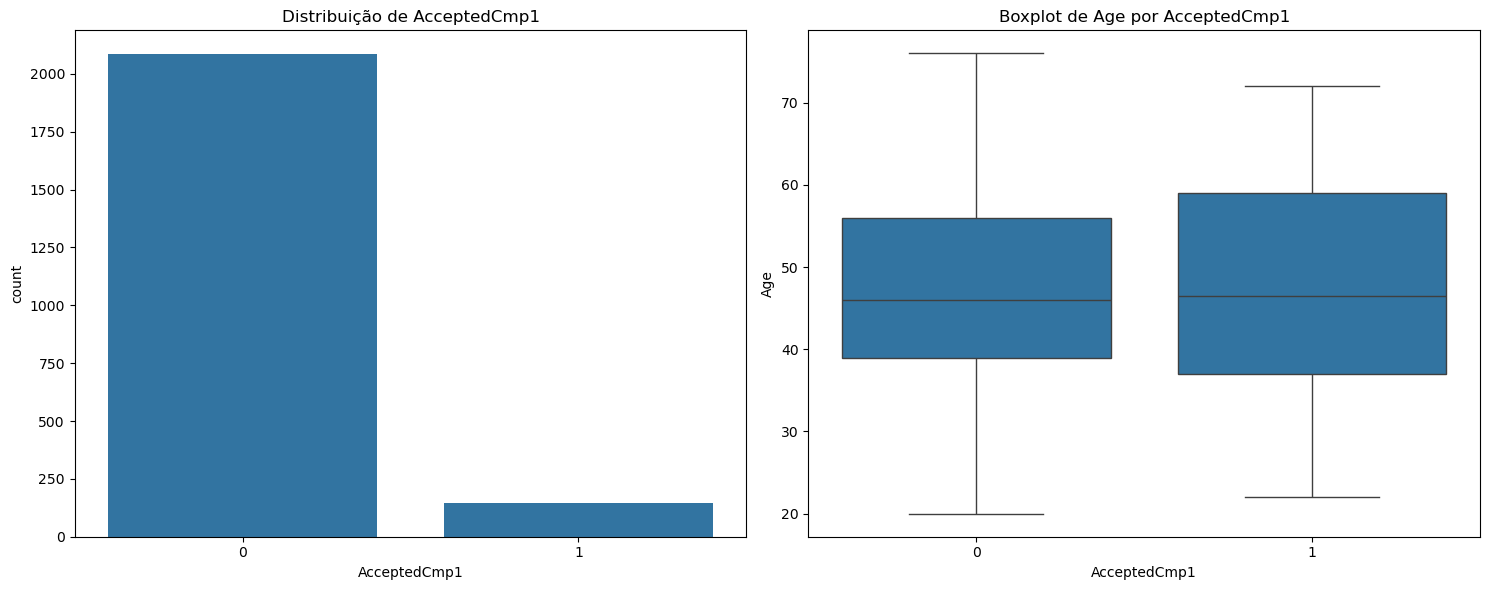

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=df_customer, x='AcceptedCmp1', ax=axes[0])
axes[0].set_title('Distribuição de AcceptedCmp1')

sns.boxplot(data=df_customer, x='AcceptedCmp1', y='Age', ax=axes[1])
axes[1].set_title('Boxplot de Age por AcceptedCmp1')

plt.tight_layout() 
plt.show()

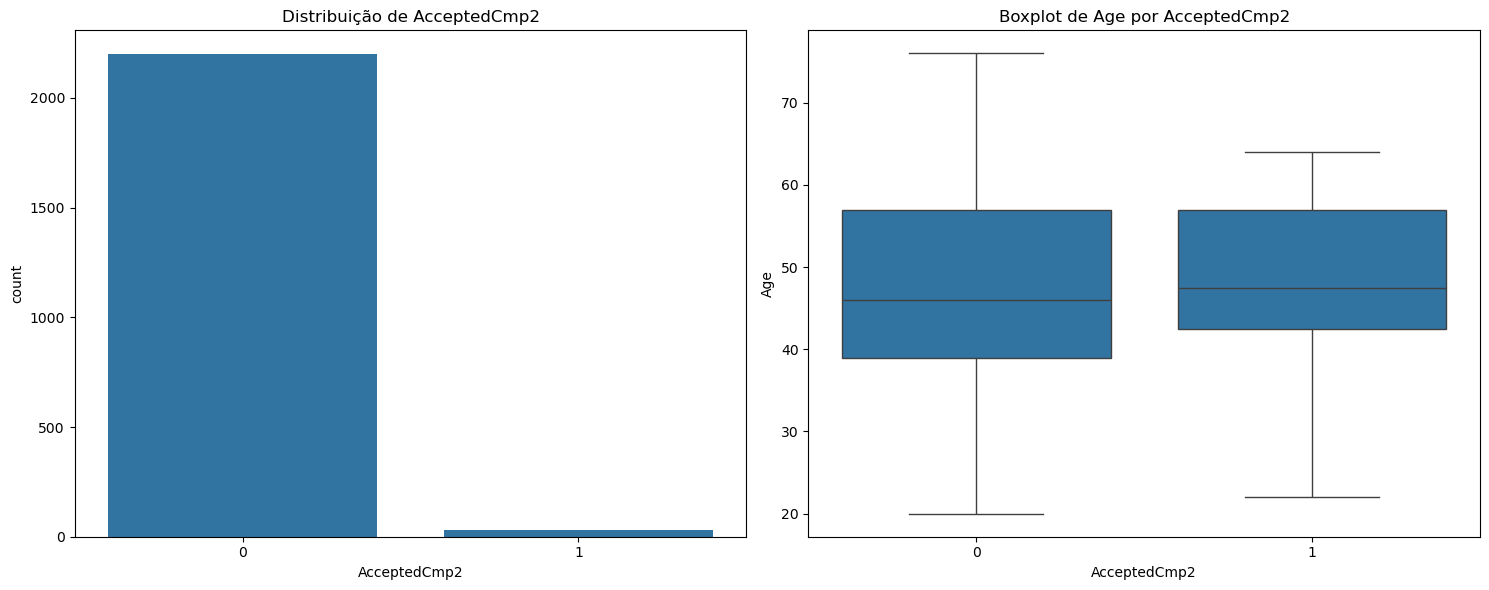

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=df_customer, x='AcceptedCmp2', ax=axes[0])
axes[0].set_title('Distribuição de AcceptedCmp2')

sns.boxplot(data=df_customer, x='AcceptedCmp2', y='Age', ax=axes[1])
axes[1].set_title('Boxplot de Age por AcceptedCmp2')

plt.tight_layout() 
plt.show()

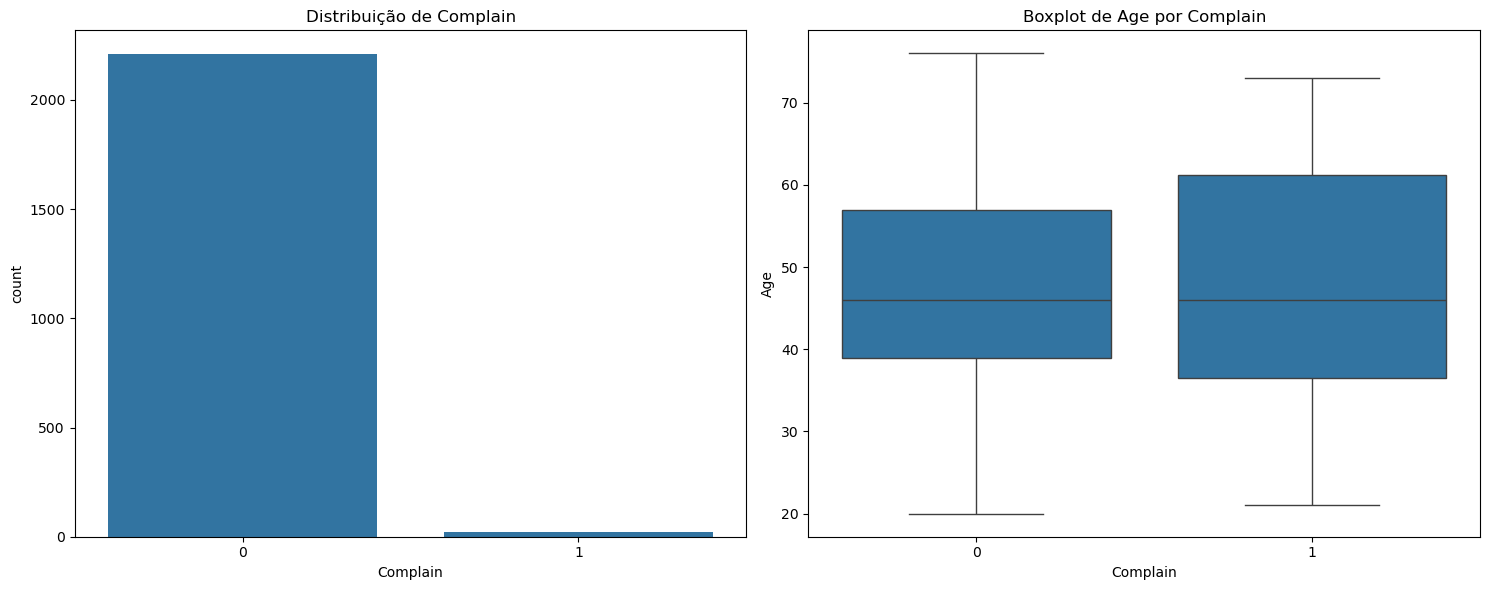

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=df_customer, x='Complain', ax=axes[0])
axes[0].set_title('Distribuição de Complain')

sns.boxplot(data=df_customer, x='Complain', y='Age', ax=axes[1])
axes[1].set_title('Boxplot de Age por Complain')

plt.tight_layout() 
plt.show()

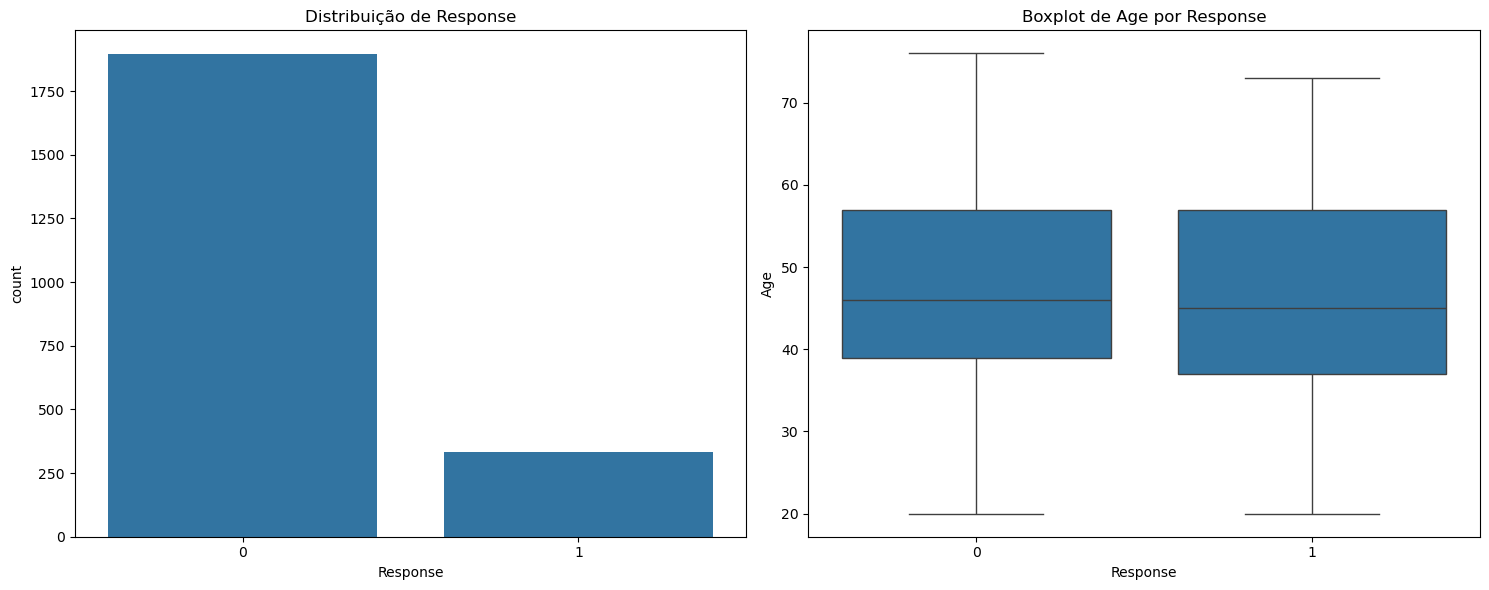

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=df_customer, x='Response', ax=axes[0])
axes[0].set_title('Distribuição de Response')

sns.boxplot(data=df_customer, x='Response', y='Age', ax=axes[1])
axes[1].set_title('Boxplot de Age por Response')

plt.tight_layout() 
plt.show()

### Pré Processamento Normalização

In [54]:
df_customer.head()

,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Month_Rel,MntWines,MntFruits,MntMeatProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,59,Graduation,Single,58138.0,0,0,51,635.0,88.0,546.0,...,10,4,7,0,0,0,0,0,0,1
2174,62,Graduation,Single,46344.0,1,1,33,11.0,1.0,6.0,...,1,2,5,0,0,0,0,0,0,0
4141,51,Graduation,Together,71613.0,0,0,40,426.0,49.0,127.0,...,2,10,4,0,0,0,0,0,0,0
6182,32,Graduation,Together,26646.0,1,0,34,11.0,4.0,20.0,...,0,4,6,0,0,0,0,0,0,0
5324,35,PhD,Married,58293.0,1,0,35,173.0,43.0,118.0,...,3,6,5,0,0,0,0,0,0,0


In [55]:
colunas_object.head()

,Education,Marital_Status,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
ID,,,,,,,,,
5524,Graduation,Single,0,0,0,0,0,0,1
2174,Graduation,Single,0,0,0,0,0,0,0
4141,Graduation,Together,0,0,0,0,0,0,0
6182,Graduation,Together,0,0,0,0,0,0,0
5324,PhD,Married,0,0,0,0,0,0,0


In [56]:
colunas_nao_object.head()

,Age,Income,Kidhome,Teenhome,Month_Rel,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
ID,,,,,,,,,,,,,,,,
5524,59,58138.0,0,0,51,635.0,88.0,546.0,172.0,88.0,88.0,3,8,10,4,7
2174,62,46344.0,1,1,33,11.0,1.0,6.0,2.0,1.0,6.0,2,1,1,2,5
4141,51,71613.0,0,0,40,426.0,49.0,127.0,111.0,21.0,42.0,1,8,2,10,4
6182,32,26646.0,1,0,34,11.0,4.0,20.0,10.0,3.0,5.0,2,2,0,4,6
5324,35,58293.0,1,0,35,173.0,43.0,118.0,46.0,27.0,15.0,5,5,3,6,5


#### Identificado se o DataFrame é clusterizavel

In [57]:
# Normalizando os dados
colunas_nao_object_norm = colunas_nao_object.copy()

scaler = MinMaxScaler(feature_range=(0, 1))

colunas_nao_object_norm = scaler.fit_transform(colunas_nao_object_norm)

In [58]:
# Aplicando Hopkins para identificar se o dataframe é clusterizavel
def hopkins_statistic(data, n=None):

    if n is None:
        n = len(data)

    data = np.array(data)
    
    random_indices = random.sample(range(len(data)), n)
    random_points = data[random_indices]
    
    d1 = []
    d2 = []
    
    for point in random_points:
        distances = distance.cdist([point], data, 'euclidean')[0]
        sorted_distances = np.sort(distances) 
        d1.append(sorted_distances[1]) 
        d2.append(sorted_distances[2])  

    D1_sum = np.sum(d1)
    D2_sum = np.sum(d2)
    
    H = D1_sum / (D1_sum + D2_sum)
    
    return H

In [59]:
# Ideal valores acima de 0.75, 0.5 indica leve tendencia de agrupamento nos dados, mas nada muito claro ou estruturado, problema com Silhouette Score
hopkins = hopkins_statistic(colunas_nao_object_norm)

print(f'Índice de Hopkins: {hopkins}')

Índice de Hopkins: 0.43361488511264


#### Reduzindo a Dimensão

In [60]:
# PCA para reduzir a dimensão, pois temos muitas variáveis
pcascale = StandardScaler()

forpca = pd.DataFrame(pcascale.fit_transform(colunas_nao_object),columns=colunas_nao_object.columns)
pca = PCA(svd_solver = 'full')
pca.fit(forpca)

PCA(svd_solver='full')

[0.40347381 0.53497961 0.62496404 0.67805585 0.72915246 0.77066289
 0.80723692 0.84136496 0.86802359 0.89437278 0.9188194  0.94200195
 0.96055286 0.97719972 0.99106551 1.        ]


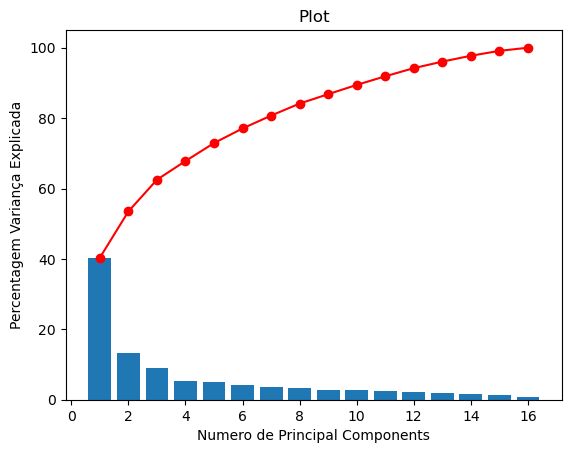

In [61]:
# Gráfico mostrando a variância acumulada explicada para identificar quantos compontes devemos escolher - 80% 
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Numero de Principal Components")
    plt.ylabel("Percentagem Variança Explicada")
    plt.title("Plot")
    plt.show(block=False)
    
expvar = np.round(pca.explained_variance_ratio_,5) 
expvar
print(pca.explained_variance_ratio_.cumsum())
display_scree_plot(pca)

In [62]:
# Detalhar 7 componentes e suas combinações

pcanew = PCA(n_components = 7,svd_solver = 'full')
pcanew.fit(forpca)

loadings = pd.DataFrame(pcanew.components_.T, columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7'], index=forpca.columns)
loadings[(loadings>0.3)|(loadings<-0.3)]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Age,NaN,NaN,0.514259,NaN,0.492160,NaN,0.437840
Income,0.338457,NaN,NaN,NaN,NaN,NaN,NaN
Kidhome,NaN,NaN,NaN,-0.405813,NaN,-0.308033,0.499049
Teenhome,NaN,0.467031,0.389979,NaN,NaN,NaN,-0.371896
Month_Rel,NaN,NaN,-0.486484,0.565992,NaN,NaN,NaN
MntWines,0.301588,NaN,NaN,NaN,-0.393703,NaN,NaN
MntFruits,NaN,NaN,NaN,NaN,0.304877,NaN,NaN
MntMeatProducts,0.320451,NaN,NaN,NaN,NaN,NaN,NaN
MntFishProducts,NaN,NaN,NaN,NaN,0.338114,NaN,NaN
MntSweetProducts,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
reduced = pd.DataFrame(pcanew.transform(forpca), columns = ['PotFinanceiro','UsoOfertas','Idade','Relacionamento','Compras','GoldToKids','TamFamilia'])
forclust = pd.concat([reduced.reset_index(drop=True),colunas_object.reset_index(drop=True)],axis = 1)

#### Identificando o número ideal de cluster

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

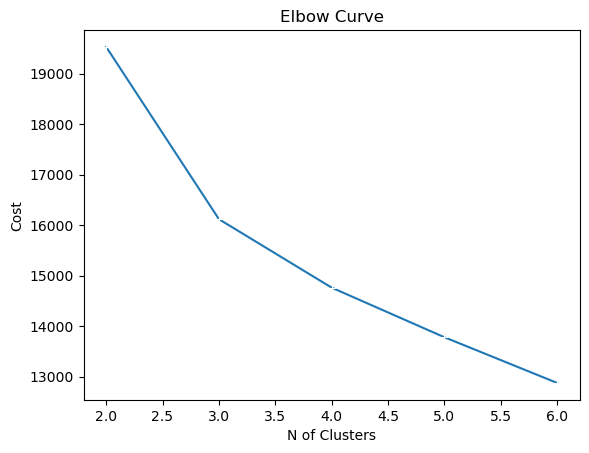

In [64]:
# Elbow com KPrototype
Poscats = forclust.select_dtypes(include='object').columns
Poscatcol = [forclust.columns.get_loc(col) for col in Poscats]

cost = []
for i in range(2,7):
    clust = KPrototypes(n_clusters = i,init='Huang',random_state=42)
    clust.fit_predict(forclust,categorical = Poscatcol)
    cost.append(clust.cost_)
    
sns.lineplot(x = range(2,7),y = cost,marker = "+",dashes = True)
plt.title('Elbow Curve')
plt.xlabel('N of Clusters')
plt.ylabel('Cost')
plt.plot

#### Modelo de Clustering

#### K-Protype

In [65]:
kprototype = KPrototypes(n_clusters = 3, 
                         init='Huang',
                         random_state=42)

kprototype.fit_predict(forclust,categorical = Poscatcol)
full = forclust.loc[:]
full['segments'] = kprototype.labels_
full.segments.value_counts()

segments
0    1023
2     615
1     590
Name: count, dtype: int64

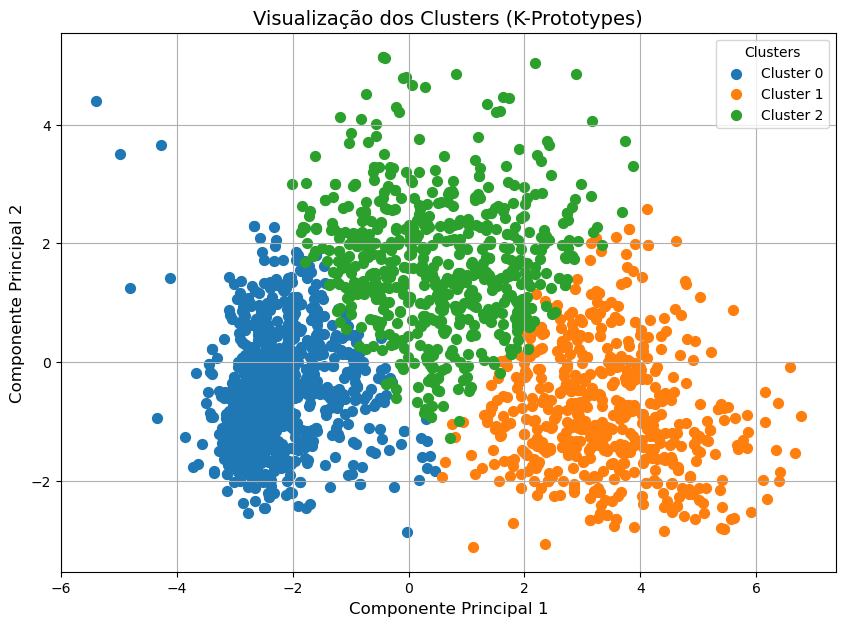

In [66]:
# Gráfico do Cluster Prototype
selected_columns = [forclust.columns[i] for i in Poscatcol]
missing_cols = [col for col in selected_columns if col not in forclust.columns]
if missing_cols:
    raise ValueError(f"As colunas {missing_cols} não foram encontradas em 'forclust'.")

encoded_full = pd.get_dummies(forclust, columns=selected_columns)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_full)

full['segments'] = kprototype.labels_

plt.figure(figsize=(10, 7))
for cluster in sorted(full['segments'].unique()):
    cluster_points = reduced_data[full['segments'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', s=50)

plt.title('Visualização dos Clusters (K-Prototypes)', fontsize=14)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Clusters', fontsize=10)
plt.grid(True)
plt.show()


In [67]:
#Silhouette Score - calcula a qualidade da separação entre clusters e varia entre -1 e +1. Mais proximo de 1 melhor
sil_score = silhouette_score(encoded_full, kprototype.labels_, metric='euclidean')

# Davies-Bouldin Index - Mede a separação entre clusters e a compactação dentro de cada cluster.. Quanto menor a metrica, melhor.
db_index = davies_bouldin_score(encoded_full, full['segments'])

# Calinski-Harabasz Index - Avalia a razão entre a dispersão entre clusters e a dispersão interna dos clusters. Valores mais altos indicam que a separação dos clusters é maior.
ch_index = calinski_harabasz_score(encoded_full, full['segments'])

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski-Harabasz Index: {ch_index}")

Silhouette Score: 0.24739728794307117
Davies-Bouldin Index: 1.577519611379662
Calinski-Harabasz Index: 884.456806245781


In [68]:
df_modelos = pd.DataFrame()

dict_kprototype = {'Algoritmo' : 'KPrototype',
                   'Silhouette Score' : sil_score,
                   'Davies-Boudin Index' : db_index,
                   'Calinski-Harabasz Index' : ch_index
                  }

new_row = pd.DataFrame([dict_kprototype])

df_modelos = pd.concat([df_modelos, new_row], ignore_index=True)
df_modelos

,Algoritmo,Silhouette Score,Davies-Boudin Index,Calinski-Harabasz Index
0,KPrototype,0.247397,1.57752,884.456806
